In [1]:
#import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from collections import defaultdict
import pandas as pd

In [2]:
np.random.seed(7)

In [3]:
def get_triplets(lst):
    """
    '1234' -> ['123','234']
    """
    res = []
    for i in range(len(lst) - 2):
        res.append(lst[i]+lst[i + 1]+lst[i + 2])
    return res


def get_dinucleotides(lst):
    """
    '123' -> ['12', '23']
    """
    res = []
    for i in range(len(lst) - 1):
        res.append(lst[i]+lst[i + 1])
    return res

In [4]:
#True: Last bases of Alus
with open('/Users/alexandershein/Code/study/CourseProject/transposones/sequences/Alu_All_50_bs_2.txt','r') as f:
    dt = np.unique(list(map(lambda x: x.strip(),f.readlines())))

In [5]:
#False: Random genome sequences
with open('/Users/alexandershein/Code/study/CourseProject/transposones/sequences/L1_last_50_bs_2.txt','r') as f:
    df = np.unique(list(map(lambda x: x.strip(),f.readlines())))


In [6]:
len(dt), len(df)

(5017, 4248)

In [7]:
# Balancing alternative
# d = df if len(df) > len(dt) else dt
p = len(df)/len(dt); m = min(p,1/p)
np.random.seed(7)
df = np.random.choice(df,round(len(df)*m), replace=False)
dt = np.random.choice(dt, len(dt), replace=False)

In [8]:
len(dt), len(df)

(5017, 3597)

In [9]:
alph = ['A','C','G','T']
alph_dict = {'A':1,'C':2,'G':3,'T':4}
pairs = [''.join(i) for i in product(alph, repeat=2)]
triplets = [''.join(i) for i in product(alph, repeat=3)]

In [10]:
x_t, y_t = [], []
for line in dt:
    row = {}
    for di_n in get_dinucleotides(line)+get_triplets(line):
        row[di_n]=row.get(di_n,0)+1
    for pos in range(len(line)):
        row[f'P{pos}']=alph_dict[line[pos]]
    y_t.append(1)
    x_t.append(row)

In [11]:
x_f, y_f = [], []
for line in df:
    row = {}
    for di_n in get_dinucleotides(line)+get_triplets(line):
        row[di_n]=row.get(di_n,0)+1
    for pos in range(len(line)):
        row[f'P{pos}']=alph_dict[line[pos]]
    y_f.append(0)
    x_f.append(row)

In [12]:
x_all = pd.DataFrame(x_t + x_f).fillna(0)
y_all = np.array(y_t + y_f)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, random_state=7, test_size=0.3)

In [14]:
np.mean(y_train), np.mean(y_test)

(0.5835130204013933, 0.5798839458413927)

In [15]:
#tr = xgboost.XGBClassifier(max_depth=5,n_estimators=100,random_state=7)
#params = {"max_depth":[5,8,11,15,20], "n_estimators":[100,1000,2000]}

In [16]:
tr = RandomForestClassifier(max_depth=5,n_estimators=100,random_state=7)
params = {"max_depth":[5,8,11,15,20], "n_estimators":[100,1000,2000]}

In [17]:
gr = GridSearchCV(tr,param_grid=params,n_jobs=6,cv=5,)

In [18]:
gr.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'max_depth': [5, 8, 11, 15, 20], 'n_estimators': [100, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
gr.best_score_, gr.best_params_

(0.999668270028197, {'max_depth': 5, 'n_estimators': 1000})

In [20]:
y_pred = gr.best_estimator_.predict(x_test)

In [21]:
roc_auc_score(y_test,y_pred)

0.9985389277320547

In [22]:
fpr, tpr, _ = roc_curve(y_test,gr.best_estimator_.predict_proba(x_test)[:,1])

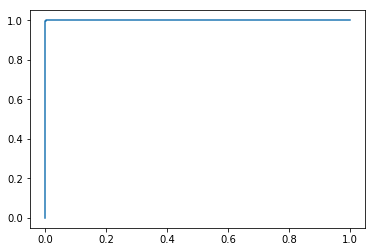

In [23]:
plt.plot(fpr,tpr);

In [24]:
auc(fpr,tpr)

0.9999981571508078

In [25]:
accuracy_score(y_test,y_pred), precision_score(y_test,y_pred), recall_score(y_test,y_pred)

(0.9984526112185687, 0.9993319973279893, 0.9979986657771848)

In [26]:
top_features = list(sorted(zip(x_train.columns, gr.best_estimator_.feature_importances_), key=lambda x: x[1], reverse=True))
top_features

[('TA', 0.09563677122541227),
 ('CTC', 0.09494510283435768),
 ('GTA', 0.08205924007848749),
 ('GA', 0.07577998473111086),
 ('TAA', 0.05891948706237251),
 ('GAG', 0.057155671980337844),
 ('GG', 0.050747258473158134),
 ('TC', 0.04974204317646193),
 ('GGG', 0.04912073797597458),
 ('AG', 0.04148371738389562),
 ('GAC', 0.03996846999493254),
 ('AGA', 0.028305557139429345),
 ('GCC', 0.027654212492417438),
 ('TAT', 0.025842375306679797),
 ('AGC', 0.024983653529830962),
 ('TGG', 0.022013295281117947),
 ('TGT', 0.016395106684183383),
 ('AT', 0.01624857895260219),
 ('CTT', 0.015151189736899473),
 ('TTA', 0.014479967855920445),
 ('TT', 0.012629557075639423),
 ('ATG', 0.01156528443735453),
 ('AA', 0.010715608669947595),
 ('GC', 0.007667078844360829),
 ('CAG', 0.006231015898917679),
 ('AAA', 0.006217264620257557),
 ('AAC', 0.005667415523627815),
 ('P49', 0.0053954672006702046),
 ('TCC', 0.005130143266746032),
 ('CTA', 0.004380309078390651),
 ('GCG', 0.00426626283939542),
 ('TAC', 0.00396802491229625

In [27]:
len(gr.best_estimator_.feature_importances_)

130

In [28]:
len(x_train.columns)

130

In [29]:
gr.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

In [30]:
pd.DataFrame(
    columns=pairs, data=[
        x_all[y_all==1][pairs].mean(),
        x_all[y_all==0][pairs].mean(),
        x_all[y_all==1][pairs].std(),
        x_all[y_all==0][pairs].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(4)

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
Mean t,2.4359,3.9113,4.6275,1.3349,4.7206,3.9384,2.6073,4.8051,4.2597,4.5266,2.3243,1.4927,0.2492,4.4443,2.9079,0.4144
Mean f,7.0778,5.2460,1.5566,4.0815,4.4532,3.1065,0.4840,3.3464,0.7520,1.8157,0.1696,3.7339,5.4295,0.7937,4.2744,2.6792
Std t,4.8658,1.0851,0.9679,0.9102,1.2823,1.2006,1.4550,1.0033,1.0555,1.2711,0.8393,0.9427,0.6344,0.8141,1.1641,0.6445
Std f,2.0768,1.2105,0.8200,1.5317,1.1419,1.1900,0.6240,0.8956,0.7065,0.7690,0.4426,1.2093,1.3904,1.0194,1.1766,1.5178


In [31]:
pd.DataFrame(
    columns=triplets, data=[
        x_all[y_all==1][triplets].mean(),
        x_all[y_all==0][triplets].mean(),
        x_all[y_all==1][triplets].std(),
        x_all[y_all==0][triplets].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(1)

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
Mean t,1.5,0.4,0.5,0.1,1.1,0.3,0.1,2.5,2.5,1.6,...,0.4,1.2,0.4,1.2,1.0,0.3,0.0,0.1,0.3,0.0
Mean f,2.9,2.4,0.9,0.9,1.9,1.7,0.4,1.3,0.5,0.1,...,0.0,0.3,0.2,1.6,0.1,2.4,1.0,0.3,0.7,0.4
Std t,4.2,0.7,0.7,0.6,0.6,0.5,0.3,0.7,0.8,0.7,...,0.5,0.5,0.6,0.7,0.3,0.5,0.1,0.3,0.5,0.2
Std f,1.6,0.9,0.5,1.1,0.9,0.8,0.6,0.7,0.6,0.3,...,0.1,0.6,0.4,0.7,0.3,1.0,0.5,0.5,0.6,1.0


In [32]:
pd.DataFrame(
    columns=x_all.columns, data=[
        x_all[y_all==1].mean(),
        x_all[y_all==0].mean(),
        x_all[y_all==1].std(),
        x_all[y_all==0].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(2)[list(filter(bool, map(lambda x: x[0] in pairs+triplets and x[0] or None, top_features)))[:20]]

,TA,CTC,GTA,GA,TAA,GAG,GG,TC,GGG,AG,GAC,AGA,GCC,TAT,AGC,TGG,TGT,AT,CTT,TTA
Mean t,0.25,2.68,0.03,4.26,0.08,1.67,2.32,4.44,1.03,4.63,1.60,2.54,1.70,0.02,1.59,1.03,0.28,1.33,0.05,0.01
Mean f,5.43,0.12,1.95,0.75,2.61,0.03,0.17,0.79,0.01,1.56,0.05,0.52,0.06,1.38,0.11,0.08,2.36,4.08,0.97,0.96
Std t,0.63,0.61,0.18,1.06,0.50,0.76,0.84,0.81,0.51,0.97,0.65,0.83,0.69,0.15,0.65,0.34,0.50,0.91,0.22,0.12
Std f,1.39,0.37,0.72,0.71,1.22,0.18,0.44,1.02,0.12,0.82,0.22,0.56,0.25,0.94,0.32,0.27,0.96,1.53,0.51,0.54
